# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

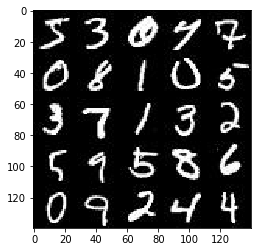

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

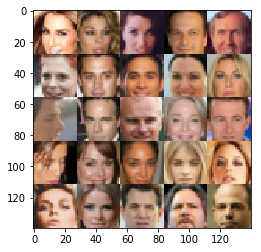

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_inputs = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels),name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    lr = tf.placeholder(tf.float32,name='lr')

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Program Files\\Miniconda3\\envs\\tf352\\lib\\runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Program Files\\Miniconda3\\envs\\tf352\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Program Files\\Miniconda3\\envs\\tf352\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Program Files\\Miniconda3\\envs\\tf352\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Program Files\\Miniconda3\\envs\\tf352\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


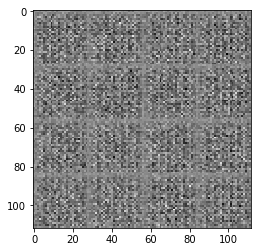

Epoch 1/2... Generator Loss: 1.3719 Discriminator Loss: 0.4698...
Epoch 1/2... Generator Loss: 1.7915 Discriminator Loss: 0.3652...
Epoch 1/2... Generator Loss: 3.6789 Discriminator Loss: 0.5677...
Epoch 1/2... Generator Loss: 1.5883 Discriminator Loss: 1.0185...
Epoch 1/2... Generator Loss: 0.7049 Discriminator Loss: 1.3294...
Epoch 1/2... Generator Loss: 0.9934 Discriminator Loss: 1.1935...
Epoch 1/2... Generator Loss: 0.6635 Discriminator Loss: 1.2820...
Epoch 1/2... Generator Loss: 1.0667 Discriminator Loss: 1.2199...
Epoch 1/2... Generator Loss: 1.2081 Discriminator Loss: 1.1531...
Epoch 1/2... Generator Loss: 1.1087 Discriminator Loss: 0.9967...


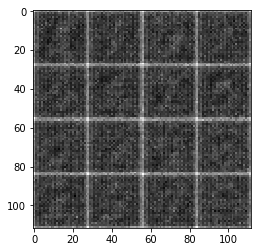

Epoch 1/2... Generator Loss: 1.1366 Discriminator Loss: 1.0799...
Epoch 1/2... Generator Loss: 0.9865 Discriminator Loss: 1.1293...
Epoch 1/2... Generator Loss: 0.9072 Discriminator Loss: 1.0929...
Epoch 1/2... Generator Loss: 1.1082 Discriminator Loss: 1.0062...
Epoch 1/2... Generator Loss: 1.3054 Discriminator Loss: 1.1149...
Epoch 1/2... Generator Loss: 0.8399 Discriminator Loss: 1.0559...
Epoch 1/2... Generator Loss: 1.9714 Discriminator Loss: 1.0128...
Epoch 1/2... Generator Loss: 1.3464 Discriminator Loss: 0.9702...
Epoch 1/2... Generator Loss: 1.2530 Discriminator Loss: 0.7546...
Epoch 1/2... Generator Loss: 1.6021 Discriminator Loss: 0.7350...


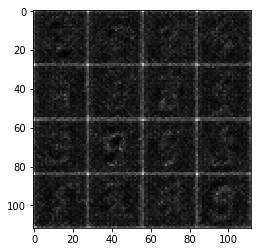

Epoch 1/2... Generator Loss: 1.6406 Discriminator Loss: 0.7293...
Epoch 1/2... Generator Loss: 1.4883 Discriminator Loss: 0.8686...
Epoch 1/2... Generator Loss: 0.5994 Discriminator Loss: 1.0633...
Epoch 1/2... Generator Loss: 1.0681 Discriminator Loss: 0.7992...
Epoch 1/2... Generator Loss: 1.3874 Discriminator Loss: 0.6821...
Epoch 1/2... Generator Loss: 1.0093 Discriminator Loss: 0.7270...
Epoch 1/2... Generator Loss: 1.4612 Discriminator Loss: 0.7299...
Epoch 1/2... Generator Loss: 1.8437 Discriminator Loss: 0.8488...
Epoch 1/2... Generator Loss: 0.7399 Discriminator Loss: 0.9948...
Epoch 1/2... Generator Loss: 1.7945 Discriminator Loss: 0.5491...


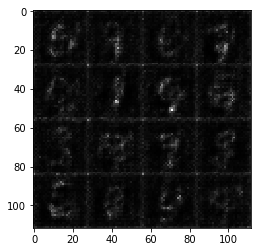

Epoch 1/2... Generator Loss: 1.2920 Discriminator Loss: 0.6547...
Epoch 1/2... Generator Loss: 1.8204 Discriminator Loss: 0.6767...
Epoch 1/2... Generator Loss: 1.7898 Discriminator Loss: 0.5637...
Epoch 1/2... Generator Loss: 1.4273 Discriminator Loss: 0.6941...
Epoch 1/2... Generator Loss: 1.7783 Discriminator Loss: 0.4392...
Epoch 1/2... Generator Loss: 1.6459 Discriminator Loss: 0.6853...
Epoch 1/2... Generator Loss: 1.5786 Discriminator Loss: 0.6141...
Epoch 1/2... Generator Loss: 2.0352 Discriminator Loss: 0.5033...
Epoch 1/2... Generator Loss: 0.7236 Discriminator Loss: 1.0643...
Epoch 1/2... Generator Loss: 1.0797 Discriminator Loss: 0.7799...


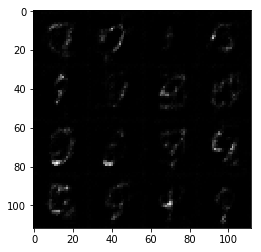

Epoch 1/2... Generator Loss: 1.7487 Discriminator Loss: 0.6224...
Epoch 1/2... Generator Loss: 1.4328 Discriminator Loss: 0.6030...
Epoch 1/2... Generator Loss: 2.2525 Discriminator Loss: 0.7695...
Epoch 1/2... Generator Loss: 1.4324 Discriminator Loss: 0.6013...
Epoch 1/2... Generator Loss: 1.3045 Discriminator Loss: 0.6054...
Epoch 1/2... Generator Loss: 2.1797 Discriminator Loss: 0.7552...
Epoch 1/2... Generator Loss: 1.2628 Discriminator Loss: 0.8354...
Epoch 1/2... Generator Loss: 1.9902 Discriminator Loss: 0.5822...
Epoch 1/2... Generator Loss: 0.9476 Discriminator Loss: 1.0208...
Epoch 1/2... Generator Loss: 0.9955 Discriminator Loss: 0.8043...


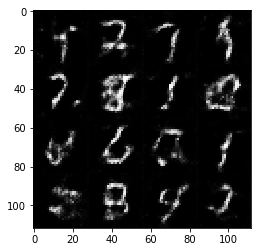

Epoch 1/2... Generator Loss: 0.6422 Discriminator Loss: 1.0570...
Epoch 1/2... Generator Loss: 0.9525 Discriminator Loss: 1.0317...
Epoch 1/2... Generator Loss: 1.9154 Discriminator Loss: 0.9415...
Epoch 1/2... Generator Loss: 0.9430 Discriminator Loss: 0.7708...
Epoch 1/2... Generator Loss: 1.6802 Discriminator Loss: 0.9878...
Epoch 1/2... Generator Loss: 0.7038 Discriminator Loss: 1.1506...
Epoch 1/2... Generator Loss: 0.6619 Discriminator Loss: 1.2394...
Epoch 1/2... Generator Loss: 1.4819 Discriminator Loss: 0.7613...
Epoch 1/2... Generator Loss: 1.0695 Discriminator Loss: 0.8985...
Epoch 1/2... Generator Loss: 0.6860 Discriminator Loss: 1.0015...


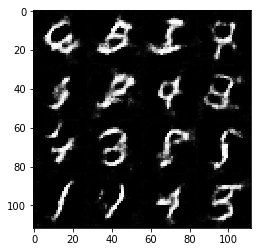

Epoch 1/2... Generator Loss: 0.8664 Discriminator Loss: 0.9733...
Epoch 1/2... Generator Loss: 1.0398 Discriminator Loss: 0.8507...
Epoch 1/2... Generator Loss: 1.2173 Discriminator Loss: 0.9983...
Epoch 1/2... Generator Loss: 2.0350 Discriminator Loss: 0.6944...
Epoch 1/2... Generator Loss: 1.4025 Discriminator Loss: 1.0341...
Epoch 1/2... Generator Loss: 0.7607 Discriminator Loss: 0.9946...
Epoch 1/2... Generator Loss: 1.2316 Discriminator Loss: 0.9472...
Epoch 1/2... Generator Loss: 0.9290 Discriminator Loss: 1.1735...
Epoch 1/2... Generator Loss: 1.3690 Discriminator Loss: 0.8023...
Epoch 1/2... Generator Loss: 1.0816 Discriminator Loss: 0.8662...


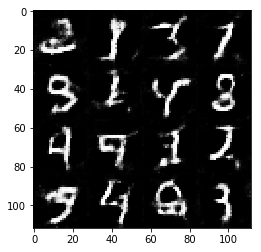

Epoch 1/2... Generator Loss: 0.5403 Discriminator Loss: 1.2805...
Epoch 1/2... Generator Loss: 1.0333 Discriminator Loss: 0.8782...
Epoch 1/2... Generator Loss: 2.0476 Discriminator Loss: 1.1266...
Epoch 1/2... Generator Loss: 1.3574 Discriminator Loss: 0.7094...
Epoch 1/2... Generator Loss: 1.0840 Discriminator Loss: 0.7575...
Epoch 1/2... Generator Loss: 1.1330 Discriminator Loss: 0.8268...
Epoch 1/2... Generator Loss: 1.1346 Discriminator Loss: 0.9335...
Epoch 1/2... Generator Loss: 0.8255 Discriminator Loss: 1.1408...
Epoch 1/2... Generator Loss: 0.8942 Discriminator Loss: 0.8962...
Epoch 1/2... Generator Loss: 0.8430 Discriminator Loss: 0.9818...


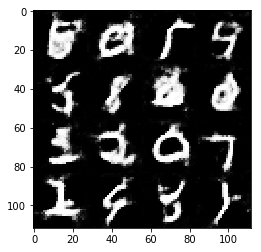

Epoch 1/2... Generator Loss: 1.2493 Discriminator Loss: 0.9996...
Epoch 1/2... Generator Loss: 1.1918 Discriminator Loss: 0.8443...
Epoch 1/2... Generator Loss: 0.9935 Discriminator Loss: 0.9647...
Epoch 1/2... Generator Loss: 0.9017 Discriminator Loss: 0.7599...
Epoch 1/2... Generator Loss: 1.7463 Discriminator Loss: 0.7632...
Epoch 1/2... Generator Loss: 1.1490 Discriminator Loss: 1.1151...
Epoch 1/2... Generator Loss: 1.1003 Discriminator Loss: 1.1609...
Epoch 1/2... Generator Loss: 1.2906 Discriminator Loss: 0.6595...
Epoch 1/2... Generator Loss: 1.3412 Discriminator Loss: 0.9074...
Epoch 1/2... Generator Loss: 1.3685 Discriminator Loss: 0.8035...


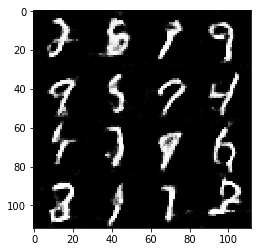

Epoch 1/2... Generator Loss: 1.0823 Discriminator Loss: 0.7924...
Epoch 1/2... Generator Loss: 0.8942 Discriminator Loss: 0.8975...
Epoch 1/2... Generator Loss: 0.6938 Discriminator Loss: 1.0746...
Epoch 2/2... Generator Loss: 1.0418 Discriminator Loss: 0.9209...
Epoch 2/2... Generator Loss: 1.4059 Discriminator Loss: 0.7625...
Epoch 2/2... Generator Loss: 0.9410 Discriminator Loss: 1.0113...
Epoch 2/2... Generator Loss: 1.2588 Discriminator Loss: 1.0272...
Epoch 2/2... Generator Loss: 0.9856 Discriminator Loss: 0.9182...
Epoch 2/2... Generator Loss: 0.9867 Discriminator Loss: 0.9682...
Epoch 2/2... Generator Loss: 0.9527 Discriminator Loss: 0.9360...


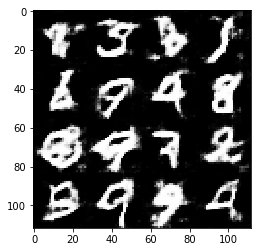

Epoch 2/2... Generator Loss: 1.3229 Discriminator Loss: 0.7489...
Epoch 2/2... Generator Loss: 1.6676 Discriminator Loss: 0.6859...
Epoch 2/2... Generator Loss: 1.4712 Discriminator Loss: 0.7391...
Epoch 2/2... Generator Loss: 0.6936 Discriminator Loss: 1.0302...
Epoch 2/2... Generator Loss: 1.5127 Discriminator Loss: 0.6456...
Epoch 2/2... Generator Loss: 1.0130 Discriminator Loss: 0.9851...
Epoch 2/2... Generator Loss: 1.4498 Discriminator Loss: 1.0386...
Epoch 2/2... Generator Loss: 1.1550 Discriminator Loss: 0.8446...
Epoch 2/2... Generator Loss: 1.6551 Discriminator Loss: 0.8486...
Epoch 2/2... Generator Loss: 1.4164 Discriminator Loss: 0.8918...


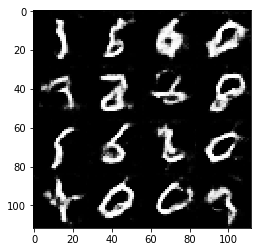

Epoch 2/2... Generator Loss: 1.4035 Discriminator Loss: 0.7418...
Epoch 2/2... Generator Loss: 1.0096 Discriminator Loss: 0.7955...
Epoch 2/2... Generator Loss: 1.5368 Discriminator Loss: 0.6639...
Epoch 2/2... Generator Loss: 1.5554 Discriminator Loss: 0.7249...
Epoch 2/2... Generator Loss: 1.2307 Discriminator Loss: 0.8946...
Epoch 2/2... Generator Loss: 0.9858 Discriminator Loss: 0.9633...
Epoch 2/2... Generator Loss: 0.9955 Discriminator Loss: 0.9750...
Epoch 2/2... Generator Loss: 0.8037 Discriminator Loss: 1.0309...
Epoch 2/2... Generator Loss: 1.2449 Discriminator Loss: 0.9071...
Epoch 2/2... Generator Loss: 0.8955 Discriminator Loss: 0.9428...


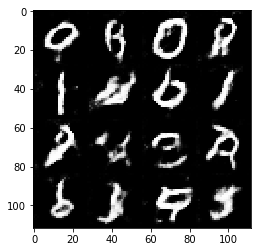

Epoch 2/2... Generator Loss: 1.4712 Discriminator Loss: 0.7580...
Epoch 2/2... Generator Loss: 1.1807 Discriminator Loss: 0.9369...
Epoch 2/2... Generator Loss: 1.6440 Discriminator Loss: 0.8887...
Epoch 2/2... Generator Loss: 0.8223 Discriminator Loss: 1.0449...
Epoch 2/2... Generator Loss: 1.6415 Discriminator Loss: 0.9523...
Epoch 2/2... Generator Loss: 1.8934 Discriminator Loss: 0.9533...
Epoch 2/2... Generator Loss: 1.1782 Discriminator Loss: 1.0674...
Epoch 2/2... Generator Loss: 1.0446 Discriminator Loss: 0.8247...
Epoch 2/2... Generator Loss: 1.1803 Discriminator Loss: 0.7790...
Epoch 2/2... Generator Loss: 1.8660 Discriminator Loss: 1.0869...


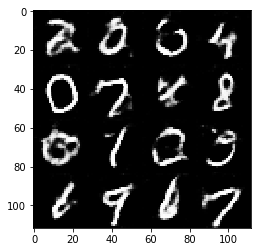

Epoch 2/2... Generator Loss: 1.1327 Discriminator Loss: 0.7986...
Epoch 2/2... Generator Loss: 1.4625 Discriminator Loss: 1.2802...
Epoch 2/2... Generator Loss: 1.2478 Discriminator Loss: 0.9339...
Epoch 2/2... Generator Loss: 1.0565 Discriminator Loss: 1.0169...
Epoch 2/2... Generator Loss: 1.5345 Discriminator Loss: 1.0591...
Epoch 2/2... Generator Loss: 0.7656 Discriminator Loss: 1.0187...
Epoch 2/2... Generator Loss: 1.5629 Discriminator Loss: 0.7597...
Epoch 2/2... Generator Loss: 1.7974 Discriminator Loss: 0.9166...
Epoch 2/2... Generator Loss: 0.7602 Discriminator Loss: 0.9140...
Epoch 2/2... Generator Loss: 1.2687 Discriminator Loss: 0.8710...


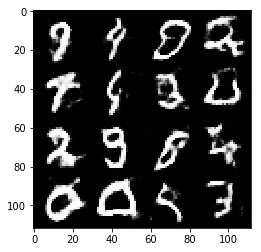

Epoch 2/2... Generator Loss: 1.3770 Discriminator Loss: 0.6665...
Epoch 2/2... Generator Loss: 1.4708 Discriminator Loss: 0.9360...
Epoch 2/2... Generator Loss: 0.5075 Discriminator Loss: 1.3407...
Epoch 2/2... Generator Loss: 1.3905 Discriminator Loss: 0.6510...
Epoch 2/2... Generator Loss: 1.8182 Discriminator Loss: 0.7689...
Epoch 2/2... Generator Loss: 1.0541 Discriminator Loss: 0.8132...
Epoch 2/2... Generator Loss: 1.1280 Discriminator Loss: 0.8419...
Epoch 2/2... Generator Loss: 0.7001 Discriminator Loss: 1.0167...
Epoch 2/2... Generator Loss: 1.4304 Discriminator Loss: 0.8509...
Epoch 2/2... Generator Loss: 1.1221 Discriminator Loss: 0.6927...


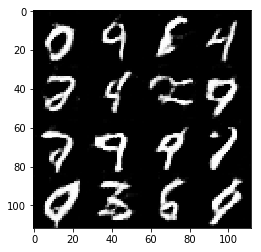

Epoch 2/2... Generator Loss: 0.8650 Discriminator Loss: 1.0243...
Epoch 2/2... Generator Loss: 1.1898 Discriminator Loss: 0.6820...
Epoch 2/2... Generator Loss: 1.4518 Discriminator Loss: 0.5908...
Epoch 2/2... Generator Loss: 1.1232 Discriminator Loss: 0.9050...
Epoch 2/2... Generator Loss: 1.0763 Discriminator Loss: 0.6647...
Epoch 2/2... Generator Loss: 1.2935 Discriminator Loss: 0.7859...
Epoch 2/2... Generator Loss: 0.9527 Discriminator Loss: 0.8970...
Epoch 2/2... Generator Loss: 0.9557 Discriminator Loss: 0.8466...
Epoch 2/2... Generator Loss: 0.8613 Discriminator Loss: 0.9412...
Epoch 2/2... Generator Loss: 1.1413 Discriminator Loss: 0.8481...


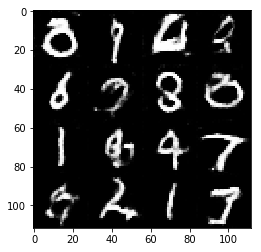

Epoch 2/2... Generator Loss: 1.1229 Discriminator Loss: 0.9594...
Epoch 2/2... Generator Loss: 0.7518 Discriminator Loss: 0.9287...
Epoch 2/2... Generator Loss: 1.4771 Discriminator Loss: 1.0287...
Epoch 2/2... Generator Loss: 0.8394 Discriminator Loss: 1.0368...
Epoch 2/2... Generator Loss: 1.5143 Discriminator Loss: 0.6607...
Epoch 2/2... Generator Loss: 1.1260 Discriminator Loss: 0.8431...
Epoch 2/2... Generator Loss: 1.2449 Discriminator Loss: 0.7215...
Epoch 2/2... Generator Loss: 1.7159 Discriminator Loss: 0.7733...
Epoch 2/2... Generator Loss: 1.0542 Discriminator Loss: 0.7890...
Epoch 2/2... Generator Loss: 1.2183 Discriminator Loss: 0.8500...


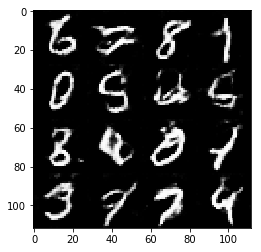

Epoch 2/2... Generator Loss: 0.5771 Discriminator Loss: 1.3044...
Epoch 2/2... Generator Loss: 0.4646 Discriminator Loss: 1.4080...
Epoch 2/2... Generator Loss: 0.8003 Discriminator Loss: 1.0663...
Epoch 2/2... Generator Loss: 2.0336 Discriminator Loss: 0.9999...
Epoch 2/2... Generator Loss: 2.0140 Discriminator Loss: 0.9906...
Epoch 2/2... Generator Loss: 1.5394 Discriminator Loss: 0.6539...
Epoch 2/2... Generator Loss: 1.1616 Discriminator Loss: 0.8541...
Epoch 2/2... Generator Loss: 1.4381 Discriminator Loss: 0.9648...
Epoch 2/2... Generator Loss: 1.4614 Discriminator Loss: 0.6214...
Epoch 2/2... Generator Loss: 1.4418 Discriminator Loss: 1.1955...


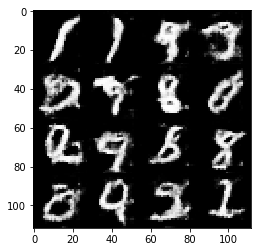

Epoch 2/2... Generator Loss: 1.0150 Discriminator Loss: 0.9628...
Epoch 2/2... Generator Loss: 0.8094 Discriminator Loss: 0.8560...
Epoch 2/2... Generator Loss: 1.0260 Discriminator Loss: 0.8372...
Epoch 2/2... Generator Loss: 1.2588 Discriminator Loss: 0.9196...
Epoch 2/2... Generator Loss: 1.5500 Discriminator Loss: 0.8190...
Epoch 2/2... Generator Loss: 1.2847 Discriminator Loss: 0.8704...
Epoch 2/2... Generator Loss: 1.4324 Discriminator Loss: 0.6384...


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


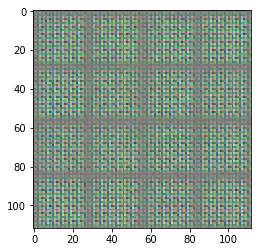

Epoch 1/1... Generator Loss: 5.5027 Discriminator Loss: 0.0163...
Epoch 1/1... Generator Loss: 5.9875 Discriminator Loss: 0.0099...
Epoch 1/1... Generator Loss: 17.4648 Discriminator Loss: 0.0033...
Epoch 1/1... Generator Loss: 25.6007 Discriminator Loss: 0.0001...
Epoch 1/1... Generator Loss: 22.1076 Discriminator Loss: 0.0101...
Epoch 1/1... Generator Loss: 1.3714 Discriminator Loss: 0.5460...
Epoch 1/1... Generator Loss: 3.6632 Discriminator Loss: 0.1029...
Epoch 1/1... Generator Loss: 2.5931 Discriminator Loss: 0.8067...
Epoch 1/1... Generator Loss: 0.1876 Discriminator Loss: 2.0316...
Epoch 1/1... Generator Loss: 1.0697 Discriminator Loss: 0.7909...


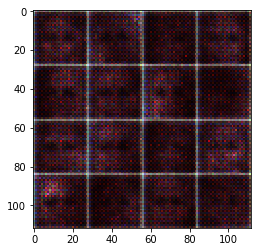

Epoch 1/1... Generator Loss: 0.2598 Discriminator Loss: 1.8762...
Epoch 1/1... Generator Loss: 8.2667 Discriminator Loss: 0.0583...
Epoch 1/1... Generator Loss: 1.8400 Discriminator Loss: 0.5106...
Epoch 1/1... Generator Loss: 1.2878 Discriminator Loss: 0.6600...
Epoch 1/1... Generator Loss: 0.8817 Discriminator Loss: 0.9130...
Epoch 1/1... Generator Loss: 1.6763 Discriminator Loss: 0.6050...
Epoch 1/1... Generator Loss: 1.4100 Discriminator Loss: 1.2374...
Epoch 1/1... Generator Loss: 0.6378 Discriminator Loss: 1.5145...
Epoch 1/1... Generator Loss: 0.5324 Discriminator Loss: 1.2844...
Epoch 1/1... Generator Loss: 1.0696 Discriminator Loss: 0.9778...


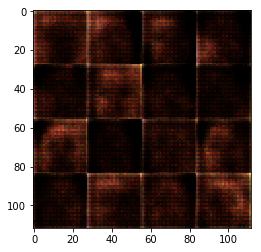

Epoch 1/1... Generator Loss: 1.4264 Discriminator Loss: 0.9823...
Epoch 1/1... Generator Loss: 1.9197 Discriminator Loss: 0.9108...
Epoch 1/1... Generator Loss: 2.2366 Discriminator Loss: 0.7854...
Epoch 1/1... Generator Loss: 2.6536 Discriminator Loss: 1.3403...
Epoch 1/1... Generator Loss: 1.2822 Discriminator Loss: 0.8532...
Epoch 1/1... Generator Loss: 0.4754 Discriminator Loss: 1.5650...
Epoch 1/1... Generator Loss: 0.8230 Discriminator Loss: 1.0358...
Epoch 1/1... Generator Loss: 1.4714 Discriminator Loss: 1.1493...
Epoch 1/1... Generator Loss: 1.5564 Discriminator Loss: 1.3097...
Epoch 1/1... Generator Loss: 5.2113 Discriminator Loss: 3.5130...


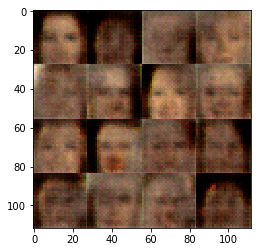

Epoch 1/1... Generator Loss: 1.4858 Discriminator Loss: 1.1496...
Epoch 1/1... Generator Loss: 1.3887 Discriminator Loss: 1.0618...
Epoch 1/1... Generator Loss: 1.1405 Discriminator Loss: 1.1521...
Epoch 1/1... Generator Loss: 2.4704 Discriminator Loss: 1.3250...
Epoch 1/1... Generator Loss: 0.6400 Discriminator Loss: 1.2146...
Epoch 1/1... Generator Loss: 0.6198 Discriminator Loss: 1.2281...
Epoch 1/1... Generator Loss: 1.6584 Discriminator Loss: 1.1588...
Epoch 1/1... Generator Loss: 0.8520 Discriminator Loss: 1.0777...
Epoch 1/1... Generator Loss: 0.7954 Discriminator Loss: 0.9462...
Epoch 1/1... Generator Loss: 1.1745 Discriminator Loss: 1.1276...


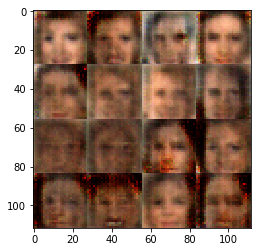

Epoch 1/1... Generator Loss: 0.8114 Discriminator Loss: 1.0776...
Epoch 1/1... Generator Loss: 1.3114 Discriminator Loss: 1.0756...
Epoch 1/1... Generator Loss: 0.2172 Discriminator Loss: 1.8668...
Epoch 1/1... Generator Loss: 1.1328 Discriminator Loss: 0.9808...
Epoch 1/1... Generator Loss: 0.6325 Discriminator Loss: 1.1846...
Epoch 1/1... Generator Loss: 1.2829 Discriminator Loss: 0.8383...
Epoch 1/1... Generator Loss: 1.5815 Discriminator Loss: 1.0794...
Epoch 1/1... Generator Loss: 1.8681 Discriminator Loss: 1.0828...
Epoch 1/1... Generator Loss: 1.9654 Discriminator Loss: 1.2443...
Epoch 1/1... Generator Loss: 1.1912 Discriminator Loss: 1.1997...


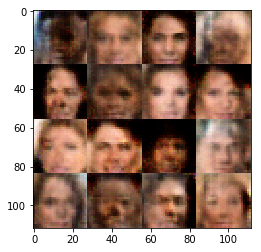

Epoch 1/1... Generator Loss: 0.5009 Discriminator Loss: 1.3157...
Epoch 1/1... Generator Loss: 0.7866 Discriminator Loss: 1.0832...
Epoch 1/1... Generator Loss: 1.3597 Discriminator Loss: 1.3004...
Epoch 1/1... Generator Loss: 0.6909 Discriminator Loss: 1.1199...
Epoch 1/1... Generator Loss: 1.4730 Discriminator Loss: 0.9134...
Epoch 1/1... Generator Loss: 1.5264 Discriminator Loss: 1.3615...
Epoch 1/1... Generator Loss: 1.1878 Discriminator Loss: 1.2601...
Epoch 1/1... Generator Loss: 1.3862 Discriminator Loss: 0.9705...
Epoch 1/1... Generator Loss: 1.4394 Discriminator Loss: 1.0552...
Epoch 1/1... Generator Loss: 0.7405 Discriminator Loss: 1.0801...


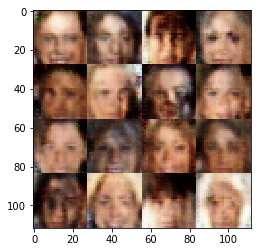

Epoch 1/1... Generator Loss: 0.4305 Discriminator Loss: 1.4615...
Epoch 1/1... Generator Loss: 0.2911 Discriminator Loss: 1.7279...
Epoch 1/1... Generator Loss: 0.8401 Discriminator Loss: 1.1719...
Epoch 1/1... Generator Loss: 2.7177 Discriminator Loss: 2.1209...
Epoch 1/1... Generator Loss: 0.4175 Discriminator Loss: 1.3985...
Epoch 1/1... Generator Loss: 0.7066 Discriminator Loss: 0.9886...
Epoch 1/1... Generator Loss: 0.4703 Discriminator Loss: 1.2256...
Epoch 1/1... Generator Loss: 0.2882 Discriminator Loss: 1.7009...
Epoch 1/1... Generator Loss: 0.3777 Discriminator Loss: 1.7241...
Epoch 1/1... Generator Loss: 0.8928 Discriminator Loss: 1.1085...


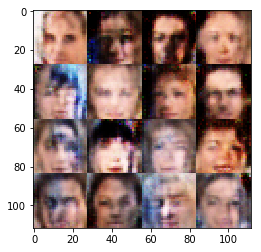

Epoch 1/1... Generator Loss: 0.9953 Discriminator Loss: 1.1028...
Epoch 1/1... Generator Loss: 0.2249 Discriminator Loss: 1.8411...
Epoch 1/1... Generator Loss: 1.0628 Discriminator Loss: 0.9879...
Epoch 1/1... Generator Loss: 0.9047 Discriminator Loss: 1.2072...
Epoch 1/1... Generator Loss: 0.9606 Discriminator Loss: 1.1414...
Epoch 1/1... Generator Loss: 0.6986 Discriminator Loss: 1.0980...
Epoch 1/1... Generator Loss: 0.9042 Discriminator Loss: 1.1731...
Epoch 1/1... Generator Loss: 1.2340 Discriminator Loss: 1.5928...
Epoch 1/1... Generator Loss: 0.5593 Discriminator Loss: 1.3249...
Epoch 1/1... Generator Loss: 0.5289 Discriminator Loss: 1.2823...


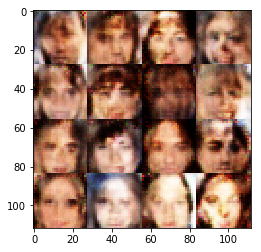

Epoch 1/1... Generator Loss: 0.8581 Discriminator Loss: 1.1241...
Epoch 1/1... Generator Loss: 0.5723 Discriminator Loss: 1.2002...
Epoch 1/1... Generator Loss: 0.4940 Discriminator Loss: 1.3712...
Epoch 1/1... Generator Loss: 0.7392 Discriminator Loss: 1.2215...
Epoch 1/1... Generator Loss: 1.0408 Discriminator Loss: 1.3371...
Epoch 1/1... Generator Loss: 0.9645 Discriminator Loss: 1.3340...
Epoch 1/1... Generator Loss: 1.0093 Discriminator Loss: 1.2713...
Epoch 1/1... Generator Loss: 0.5956 Discriminator Loss: 1.2860...
Epoch 1/1... Generator Loss: 1.0590 Discriminator Loss: 1.1639...
Epoch 1/1... Generator Loss: 0.6549 Discriminator Loss: 1.3835...


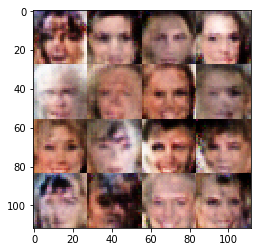

Epoch 1/1... Generator Loss: 0.5654 Discriminator Loss: 1.3053...
Epoch 1/1... Generator Loss: 0.8955 Discriminator Loss: 1.1753...
Epoch 1/1... Generator Loss: 0.5042 Discriminator Loss: 1.4047...
Epoch 1/1... Generator Loss: 0.8608 Discriminator Loss: 1.2280...
Epoch 1/1... Generator Loss: 1.0002 Discriminator Loss: 1.1917...
Epoch 1/1... Generator Loss: 0.3395 Discriminator Loss: 1.5923...
Epoch 1/1... Generator Loss: 0.8176 Discriminator Loss: 1.1081...
Epoch 1/1... Generator Loss: 0.2671 Discriminator Loss: 1.6853...
Epoch 1/1... Generator Loss: 0.9628 Discriminator Loss: 1.3136...
Epoch 1/1... Generator Loss: 1.1414 Discriminator Loss: 1.4798...


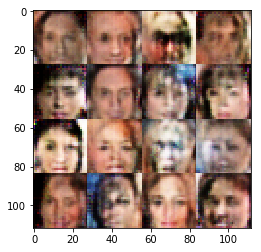

Epoch 1/1... Generator Loss: 1.0111 Discriminator Loss: 1.3435...
Epoch 1/1... Generator Loss: 0.5158 Discriminator Loss: 1.3926...
Epoch 1/1... Generator Loss: 0.3235 Discriminator Loss: 1.6353...
Epoch 1/1... Generator Loss: 0.7462 Discriminator Loss: 1.3686...
Epoch 1/1... Generator Loss: 0.6175 Discriminator Loss: 1.3255...
Epoch 1/1... Generator Loss: 0.8522 Discriminator Loss: 1.4747...
Epoch 1/1... Generator Loss: 0.6711 Discriminator Loss: 1.3454...
Epoch 1/1... Generator Loss: 0.6018 Discriminator Loss: 1.3259...
Epoch 1/1... Generator Loss: 0.5926 Discriminator Loss: 1.2188...
Epoch 1/1... Generator Loss: 0.5006 Discriminator Loss: 1.4108...


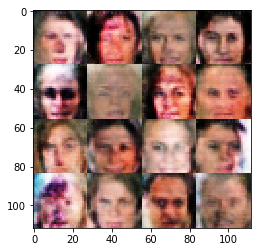

Epoch 1/1... Generator Loss: 0.7443 Discriminator Loss: 1.3277...
Epoch 1/1... Generator Loss: 0.8312 Discriminator Loss: 1.4622...
Epoch 1/1... Generator Loss: 0.5196 Discriminator Loss: 1.4779...
Epoch 1/1... Generator Loss: 0.6429 Discriminator Loss: 1.2010...
Epoch 1/1... Generator Loss: 0.8764 Discriminator Loss: 1.2108...
Epoch 1/1... Generator Loss: 0.9539 Discriminator Loss: 1.2766...
Epoch 1/1... Generator Loss: 0.7739 Discriminator Loss: 1.3427...
Epoch 1/1... Generator Loss: 0.7292 Discriminator Loss: 1.2696...
Epoch 1/1... Generator Loss: 0.8252 Discriminator Loss: 1.3222...
Epoch 1/1... Generator Loss: 0.6056 Discriminator Loss: 1.3074...


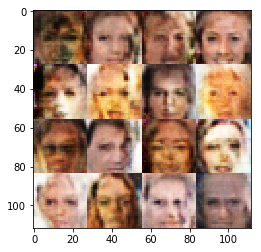

Epoch 1/1... Generator Loss: 0.7807 Discriminator Loss: 1.2752...
Epoch 1/1... Generator Loss: 0.7432 Discriminator Loss: 1.4495...
Epoch 1/1... Generator Loss: 0.9733 Discriminator Loss: 1.1779...
Epoch 1/1... Generator Loss: 0.5219 Discriminator Loss: 1.4549...
Epoch 1/1... Generator Loss: 0.6688 Discriminator Loss: 1.3271...
Epoch 1/1... Generator Loss: 0.7779 Discriminator Loss: 1.1843...
Epoch 1/1... Generator Loss: 0.6400 Discriminator Loss: 1.3942...
Epoch 1/1... Generator Loss: 0.4276 Discriminator Loss: 1.4542...
Epoch 1/1... Generator Loss: 0.7375 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.6221 Discriminator Loss: 1.3284...


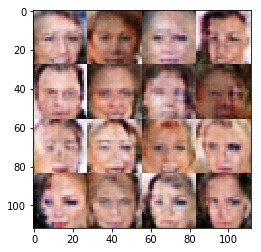

Epoch 1/1... Generator Loss: 0.7460 Discriminator Loss: 1.2804...
Epoch 1/1... Generator Loss: 0.4806 Discriminator Loss: 1.6136...
Epoch 1/1... Generator Loss: 0.9130 Discriminator Loss: 1.1617...
Epoch 1/1... Generator Loss: 0.6016 Discriminator Loss: 1.3164...
Epoch 1/1... Generator Loss: 0.5186 Discriminator Loss: 1.4868...
Epoch 1/1... Generator Loss: 0.5980 Discriminator Loss: 1.2510...
Epoch 1/1... Generator Loss: 0.6724 Discriminator Loss: 1.3995...
Epoch 1/1... Generator Loss: 0.6136 Discriminator Loss: 1.3253...
Epoch 1/1... Generator Loss: 0.6842 Discriminator Loss: 1.4743...
Epoch 1/1... Generator Loss: 0.8913 Discriminator Loss: 1.2486...


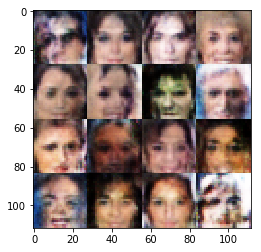

Epoch 1/1... Generator Loss: 0.5853 Discriminator Loss: 1.5127...
Epoch 1/1... Generator Loss: 0.4660 Discriminator Loss: 1.4096...
Epoch 1/1... Generator Loss: 0.9557 Discriminator Loss: 1.2836...
Epoch 1/1... Generator Loss: 0.6713 Discriminator Loss: 1.2168...
Epoch 1/1... Generator Loss: 0.7680 Discriminator Loss: 1.1883...
Epoch 1/1... Generator Loss: 0.7214 Discriminator Loss: 1.2548...
Epoch 1/1... Generator Loss: 0.7665 Discriminator Loss: 1.4200...
Epoch 1/1... Generator Loss: 0.5043 Discriminator Loss: 1.3277...
Epoch 1/1... Generator Loss: 0.8449 Discriminator Loss: 1.2003...
Epoch 1/1... Generator Loss: 0.5833 Discriminator Loss: 1.3348...


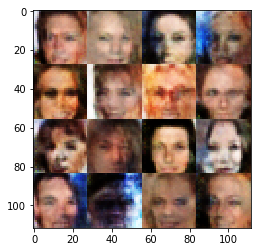

Epoch 1/1... Generator Loss: 0.7381 Discriminator Loss: 1.3689...
Epoch 1/1... Generator Loss: 1.0362 Discriminator Loss: 1.1545...
Epoch 1/1... Generator Loss: 0.6545 Discriminator Loss: 1.2975...
Epoch 1/1... Generator Loss: 0.7026 Discriminator Loss: 1.2852...
Epoch 1/1... Generator Loss: 0.6337 Discriminator Loss: 1.3300...
Epoch 1/1... Generator Loss: 0.7414 Discriminator Loss: 1.2539...
Epoch 1/1... Generator Loss: 0.6971 Discriminator Loss: 1.3104...
Epoch 1/1... Generator Loss: 0.5912 Discriminator Loss: 1.4075...
Epoch 1/1... Generator Loss: 0.6948 Discriminator Loss: 1.2814...
Epoch 1/1... Generator Loss: 0.7757 Discriminator Loss: 1.3759...


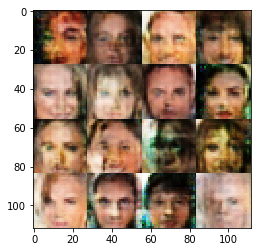

Epoch 1/1... Generator Loss: 0.7448 Discriminator Loss: 1.3328...
Epoch 1/1... Generator Loss: 0.7077 Discriminator Loss: 1.4115...
Epoch 1/1... Generator Loss: 0.5037 Discriminator Loss: 1.4821...
Epoch 1/1... Generator Loss: 0.5125 Discriminator Loss: 1.3732...
Epoch 1/1... Generator Loss: 0.6336 Discriminator Loss: 1.3377...
Epoch 1/1... Generator Loss: 0.7165 Discriminator Loss: 1.3006...
Epoch 1/1... Generator Loss: 0.5608 Discriminator Loss: 1.3248...
Epoch 1/1... Generator Loss: 0.7632 Discriminator Loss: 1.4189...
Epoch 1/1... Generator Loss: 0.6136 Discriminator Loss: 1.3923...
Epoch 1/1... Generator Loss: 0.7756 Discriminator Loss: 1.2885...


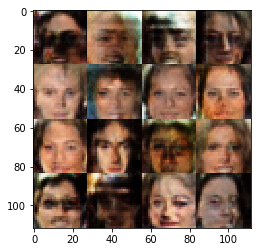

Epoch 1/1... Generator Loss: 0.8690 Discriminator Loss: 1.1251...
Epoch 1/1... Generator Loss: 0.7313 Discriminator Loss: 1.2838...
Epoch 1/1... Generator Loss: 1.1046 Discriminator Loss: 1.1517...
Epoch 1/1... Generator Loss: 0.6079 Discriminator Loss: 1.4147...
Epoch 1/1... Generator Loss: 0.6879 Discriminator Loss: 1.0273...
Epoch 1/1... Generator Loss: 0.8493 Discriminator Loss: 1.2504...
Epoch 1/1... Generator Loss: 0.9317 Discriminator Loss: 1.4302...
Epoch 1/1... Generator Loss: 0.5514 Discriminator Loss: 1.5134...
Epoch 1/1... Generator Loss: 0.6328 Discriminator Loss: 1.3021...
Epoch 1/1... Generator Loss: 0.5570 Discriminator Loss: 1.2713...


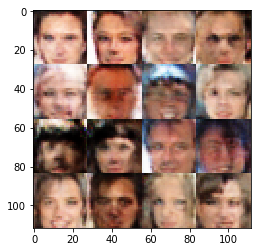

Epoch 1/1... Generator Loss: 0.7524 Discriminator Loss: 1.3508...
Epoch 1/1... Generator Loss: 0.7270 Discriminator Loss: 1.3326...
Epoch 1/1... Generator Loss: 0.6308 Discriminator Loss: 1.4227...
Epoch 1/1... Generator Loss: 0.6263 Discriminator Loss: 1.2694...
Epoch 1/1... Generator Loss: 0.7387 Discriminator Loss: 1.1822...
Epoch 1/1... Generator Loss: 0.7768 Discriminator Loss: 1.3489...
Epoch 1/1... Generator Loss: 0.4179 Discriminator Loss: 1.4376...
Epoch 1/1... Generator Loss: 0.7383 Discriminator Loss: 1.3490...
Epoch 1/1... Generator Loss: 0.9808 Discriminator Loss: 1.1064...
Epoch 1/1... Generator Loss: 0.6170 Discriminator Loss: 1.3827...


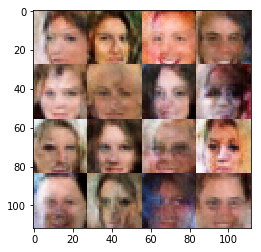

Epoch 1/1... Generator Loss: 0.6974 Discriminator Loss: 1.4418...
Epoch 1/1... Generator Loss: 0.5066 Discriminator Loss: 1.3689...
Epoch 1/1... Generator Loss: 0.8141 Discriminator Loss: 1.2113...
Epoch 1/1... Generator Loss: 0.6491 Discriminator Loss: 1.3988...
Epoch 1/1... Generator Loss: 0.9233 Discriminator Loss: 1.4014...
Epoch 1/1... Generator Loss: 0.8209 Discriminator Loss: 1.1513...
Epoch 1/1... Generator Loss: 0.4806 Discriminator Loss: 1.2874...
Epoch 1/1... Generator Loss: 0.7417 Discriminator Loss: 1.3125...
Epoch 1/1... Generator Loss: 0.7049 Discriminator Loss: 1.6268...
Epoch 1/1... Generator Loss: 0.7080 Discriminator Loss: 1.2141...


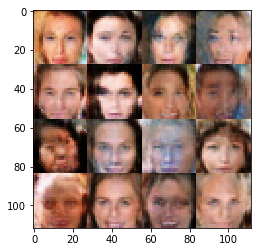

Epoch 1/1... Generator Loss: 0.5784 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.6091 Discriminator Loss: 1.3021...
Epoch 1/1... Generator Loss: 0.7798 Discriminator Loss: 1.4286...
Epoch 1/1... Generator Loss: 0.8216 Discriminator Loss: 1.3781...
Epoch 1/1... Generator Loss: 0.7517 Discriminator Loss: 1.1743...
Epoch 1/1... Generator Loss: 0.6717 Discriminator Loss: 1.2834...
Epoch 1/1... Generator Loss: 0.7138 Discriminator Loss: 1.2512...
Epoch 1/1... Generator Loss: 0.7014 Discriminator Loss: 1.2669...
Epoch 1/1... Generator Loss: 0.4075 Discriminator Loss: 1.6251...
Epoch 1/1... Generator Loss: 0.8005 Discriminator Loss: 1.3056...


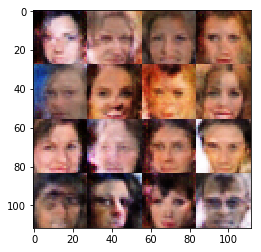

Epoch 1/1... Generator Loss: 0.4645 Discriminator Loss: 1.4904...
Epoch 1/1... Generator Loss: 0.5994 Discriminator Loss: 1.3991...
Epoch 1/1... Generator Loss: 0.6577 Discriminator Loss: 1.3706...
Epoch 1/1... Generator Loss: 0.8589 Discriminator Loss: 1.3427...
Epoch 1/1... Generator Loss: 0.7203 Discriminator Loss: 1.3010...
Epoch 1/1... Generator Loss: 0.6450 Discriminator Loss: 1.3760...
Epoch 1/1... Generator Loss: 0.6723 Discriminator Loss: 1.2427...
Epoch 1/1... Generator Loss: 0.8124 Discriminator Loss: 1.1379...
Epoch 1/1... Generator Loss: 0.6272 Discriminator Loss: 1.3810...
Epoch 1/1... Generator Loss: 0.7842 Discriminator Loss: 1.2747...


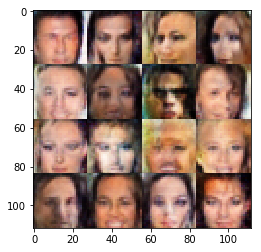

Epoch 1/1... Generator Loss: 0.5793 Discriminator Loss: 1.4182...
Epoch 1/1... Generator Loss: 0.7834 Discriminator Loss: 1.2137...
Epoch 1/1... Generator Loss: 0.7823 Discriminator Loss: 1.2825...
Epoch 1/1... Generator Loss: 0.6190 Discriminator Loss: 1.3579...
Epoch 1/1... Generator Loss: 0.8317 Discriminator Loss: 1.2455...
Epoch 1/1... Generator Loss: 0.8550 Discriminator Loss: 1.2844...
Epoch 1/1... Generator Loss: 0.6191 Discriminator Loss: 1.2509...
Epoch 1/1... Generator Loss: 0.9689 Discriminator Loss: 1.2220...
Epoch 1/1... Generator Loss: 0.8567 Discriminator Loss: 1.1870...
Epoch 1/1... Generator Loss: 1.1130 Discriminator Loss: 1.0777...


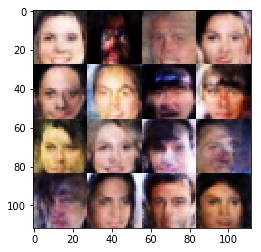

Epoch 1/1... Generator Loss: 0.7673 Discriminator Loss: 1.2247...
Epoch 1/1... Generator Loss: 0.6632 Discriminator Loss: 1.3535...
Epoch 1/1... Generator Loss: 0.6880 Discriminator Loss: 1.3041...
Epoch 1/1... Generator Loss: 0.6137 Discriminator Loss: 1.2557...
Epoch 1/1... Generator Loss: 0.6828 Discriminator Loss: 1.3741...
Epoch 1/1... Generator Loss: 0.8237 Discriminator Loss: 1.1808...
Epoch 1/1... Generator Loss: 0.6343 Discriminator Loss: 1.3978...
Epoch 1/1... Generator Loss: 0.5882 Discriminator Loss: 1.4103...
Epoch 1/1... Generator Loss: 0.7123 Discriminator Loss: 1.3249...
Epoch 1/1... Generator Loss: 0.7706 Discriminator Loss: 1.2985...


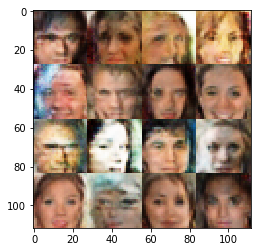

Epoch 1/1... Generator Loss: 0.5366 Discriminator Loss: 1.3348...
Epoch 1/1... Generator Loss: 0.4677 Discriminator Loss: 1.3485...
Epoch 1/1... Generator Loss: 0.8879 Discriminator Loss: 1.2228...
Epoch 1/1... Generator Loss: 0.5323 Discriminator Loss: 1.4374...
Epoch 1/1... Generator Loss: 0.6699 Discriminator Loss: 1.2582...
Epoch 1/1... Generator Loss: 0.6588 Discriminator Loss: 1.2924...
Epoch 1/1... Generator Loss: 0.6279 Discriminator Loss: 1.3853...
Epoch 1/1... Generator Loss: 0.7648 Discriminator Loss: 1.2807...
Epoch 1/1... Generator Loss: 0.8413 Discriminator Loss: 1.2720...
Epoch 1/1... Generator Loss: 0.7480 Discriminator Loss: 1.2459...


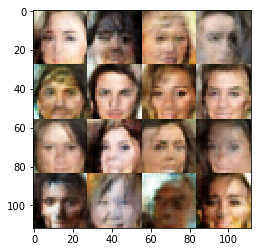

Epoch 1/1... Generator Loss: 0.5817 Discriminator Loss: 1.4475...
Epoch 1/1... Generator Loss: 0.7737 Discriminator Loss: 1.2728...
Epoch 1/1... Generator Loss: 0.7459 Discriminator Loss: 1.3890...
Epoch 1/1... Generator Loss: 0.7143 Discriminator Loss: 1.2435...
Epoch 1/1... Generator Loss: 0.6481 Discriminator Loss: 1.4382...
Epoch 1/1... Generator Loss: 0.8603 Discriminator Loss: 1.2951...
Epoch 1/1... Generator Loss: 0.7702 Discriminator Loss: 1.3990...
Epoch 1/1... Generator Loss: 0.8676 Discriminator Loss: 1.2727...
Epoch 1/1... Generator Loss: 0.6703 Discriminator Loss: 1.4120...
Epoch 1/1... Generator Loss: 0.6944 Discriminator Loss: 1.2077...


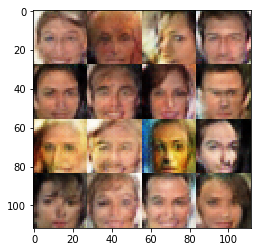

Epoch 1/1... Generator Loss: 0.6954 Discriminator Loss: 1.4790...
Epoch 1/1... Generator Loss: 0.7005 Discriminator Loss: 1.3427...
Epoch 1/1... Generator Loss: 0.6260 Discriminator Loss: 1.3388...
Epoch 1/1... Generator Loss: 0.6767 Discriminator Loss: 1.4357...
Epoch 1/1... Generator Loss: 0.7922 Discriminator Loss: 1.2771...
Epoch 1/1... Generator Loss: 0.8414 Discriminator Loss: 1.2223...
Epoch 1/1... Generator Loss: 0.6458 Discriminator Loss: 1.4272...
Epoch 1/1... Generator Loss: 0.6461 Discriminator Loss: 1.3272...
Epoch 1/1... Generator Loss: 0.4898 Discriminator Loss: 1.4041...
Epoch 1/1... Generator Loss: 0.8565 Discriminator Loss: 1.2673...


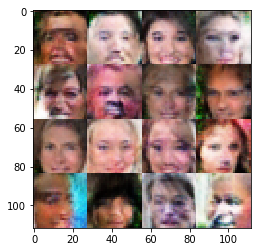

Epoch 1/1... Generator Loss: 0.8255 Discriminator Loss: 1.1942...
Epoch 1/1... Generator Loss: 0.6692 Discriminator Loss: 1.2990...
Epoch 1/1... Generator Loss: 0.5448 Discriminator Loss: 1.5130...
Epoch 1/1... Generator Loss: 0.6527 Discriminator Loss: 1.3582...
Epoch 1/1... Generator Loss: 0.5941 Discriminator Loss: 1.3041...
Epoch 1/1... Generator Loss: 0.7151 Discriminator Loss: 1.3224...
Epoch 1/1... Generator Loss: 0.7340 Discriminator Loss: 1.2384...
Epoch 1/1... Generator Loss: 0.4918 Discriminator Loss: 1.4804...
Epoch 1/1... Generator Loss: 0.6346 Discriminator Loss: 1.3940...
Epoch 1/1... Generator Loss: 0.6826 Discriminator Loss: 1.3761...


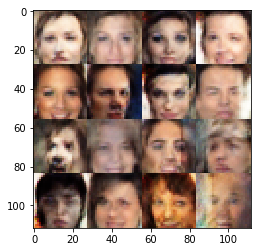

Epoch 1/1... Generator Loss: 0.7232 Discriminator Loss: 1.3187...
Epoch 1/1... Generator Loss: 0.8098 Discriminator Loss: 1.2637...
Epoch 1/1... Generator Loss: 0.5633 Discriminator Loss: 1.4028...
Epoch 1/1... Generator Loss: 0.8285 Discriminator Loss: 1.3375...
Epoch 1/1... Generator Loss: 0.6980 Discriminator Loss: 1.2821...
Epoch 1/1... Generator Loss: 0.7750 Discriminator Loss: 1.3179...
Epoch 1/1... Generator Loss: 0.6707 Discriminator Loss: 1.2895...
Epoch 1/1... Generator Loss: 0.6982 Discriminator Loss: 1.3544...
Epoch 1/1... Generator Loss: 0.6099 Discriminator Loss: 1.2852...
Epoch 1/1... Generator Loss: 0.6991 Discriminator Loss: 1.2876...


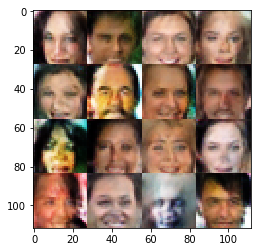

Epoch 1/1... Generator Loss: 0.6127 Discriminator Loss: 1.2374...
Epoch 1/1... Generator Loss: 0.7458 Discriminator Loss: 1.2832...
Epoch 1/1... Generator Loss: 0.5670 Discriminator Loss: 1.5342...
Epoch 1/1... Generator Loss: 0.6810 Discriminator Loss: 1.2953...
Epoch 1/1... Generator Loss: 0.6850 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 0.8538 Discriminator Loss: 1.1223...
Epoch 1/1... Generator Loss: 0.6304 Discriminator Loss: 1.2426...
Epoch 1/1... Generator Loss: 0.5489 Discriminator Loss: 1.4209...
Epoch 1/1... Generator Loss: 0.9064 Discriminator Loss: 1.2992...
Epoch 1/1... Generator Loss: 0.6473 Discriminator Loss: 1.2608...


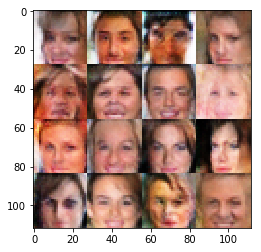

Epoch 1/1... Generator Loss: 0.8264 Discriminator Loss: 1.3567...
Epoch 1/1... Generator Loss: 0.6063 Discriminator Loss: 1.4211...
Epoch 1/1... Generator Loss: 0.7632 Discriminator Loss: 1.2721...
Epoch 1/1... Generator Loss: 0.6514 Discriminator Loss: 1.5247...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.3259...
Epoch 1/1... Generator Loss: 0.7592 Discriminator Loss: 1.4147...
Epoch 1/1... Generator Loss: 0.8985 Discriminator Loss: 1.2643...
Epoch 1/1... Generator Loss: 0.7335 Discriminator Loss: 1.2945...
Epoch 1/1... Generator Loss: 0.6976 Discriminator Loss: 1.2860...
Epoch 1/1... Generator Loss: 0.6297 Discriminator Loss: 1.3404...


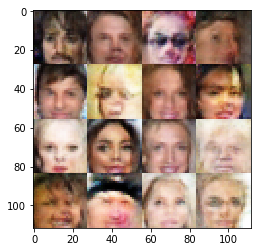

Epoch 1/1... Generator Loss: 0.6618 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.6619 Discriminator Loss: 1.3447...
Epoch 1/1... Generator Loss: 0.8491 Discriminator Loss: 1.2283...
Epoch 1/1... Generator Loss: 0.6875 Discriminator Loss: 1.2645...
Epoch 1/1... Generator Loss: 0.6657 Discriminator Loss: 1.4245...
Epoch 1/1... Generator Loss: 0.6889 Discriminator Loss: 1.2695...


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.